## RAG Pipeline

### Imports

In [1]:
import torch
import os

from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader, DirectoryLoader

# pdf loader

from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader
import pymupdf

# chunk splitter

from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import uuid
import chromadb
from chromadb.config import Settings
import shutil

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from tqdm import tqdm

# for invoking llms

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

# llava & qwen

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig, LlavaNextProcessor, LlavaNextForConditionalGeneration
from transformers import Qwen3VLForConditionalGeneration
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import accelerate
from transformers.utils.import_utils import is_accelerate_available
import requests

# plotting

import matplotlib.pyplot as plt


c:\Users\rozku\Desktop\Research_Internship\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print("python:", __import__("sys").executable)
print("is_accelerate_available:", is_accelerate_available())


2.7.0+cu128
True
1
0
python: c:\Users\rozku\Desktop\Research_Internship\Project\.venv\Scripts\python.exe
is_accelerate_available: True


In [3]:
######### General Configurations #########
documents_path = "../documents/" # relative path of all doc directories
vectordb_path = documents_path + "vectorDB/"
chunking_size = 1000  # Size of each chunk
chunking_step = 200 # Step size btw chunks

embedding_model_name = 'all-MiniLM-L6-v2'  # SentenceTransformer model name
image_embedding_model_name = "openai/clip-vit-large-patch14"  # CLIP model name


In [4]:
### Custom class for extracting images from PDFs as LangChain Documents

# --- Extended: page rendering support ---

class PdfImagesLoader:
    """
    Extracts images from a PDF and returns one LangChain Document per image.
    Optionally saves each page as image.
    """
    def __init__(
        self,
        pdf_path: str,
        images_root_dir: str,
        min_dim: int = 50,            # skip tiny images
        min_bytes: int = 0,           # skip small files
        min_bytes_per_px: float = 0,  # filter very compressed images if > 0
        extract_page_text: bool = True,
        store_to_folder: bool = True,
        pages_as_images: bool = False,
        pages_root_dir: str | None = None,
        page_zoom: float = 2.0,       # 1.0 ≈ 72dpi, 2.0 ≈ ~144dpi, 2 is usually good
    ):
        self.pdf_path = pdf_path
        self.images_root_dir = images_root_dir
        self.min_dim = min_dim
        self.min_bytes = min_bytes
        self.min_bytes_per_px = min_bytes_per_px
        self.extract_page_text = extract_page_text
        self.store_to_folder = store_to_folder

        self.pages_as_images = pages_as_images
        self.pages_root_dir = pages_root_dir
        self.page_zoom = page_zoom

    # this function is not my own, taken from pymupdf docs
    @staticmethod
    def _recover_pix(doc, xref, smask):
        if smask and smask > 0:
            base = pymupdf.Pixmap(doc.extract_image(xref)["image"])
            if base.alpha:
                base = pymupdf.Pixmap(base, 0)
            mask = pymupdf.Pixmap(doc.extract_image(smask)["image"])
            try:
                pix = pymupdf.Pixmap(base, mask)
            except Exception:
                pix = pymupdf.Pixmap(doc.extract_image(xref)["image"])
            ext = "pam" if (getattr(base, "n", 3) > 3) else "png"
            return {
                "ext": ext,
                "colorspace": pix.colorspace.n if pix.colorspace else 3,
                "image": pix.tobytes(ext),
            }

        if "/ColorSpace" in doc.xref_object(xref, compressed=True):
            pix = pymupdf.Pixmap(doc, xref)
            pix = pymupdf.Pixmap(pymupdf.csRGB, pix)
            return {"ext": "png", "colorspace": 3, "image": pix.tobytes("png")}

        return doc.extract_image(xref)

    def _render_page(self, page, out_dir_pages, pdf_stem, pdf_name, page_text):
        """Render a single page to PNG and return a Document."""
        page_num = page.number + 1
        
        mat = pymupdf.Matrix(self.page_zoom, self.page_zoom)
        pix = page.get_pixmap(matrix=mat)  # RGB 
        width, height = pix.width, pix.height
        filename = f"{pdf_stem}_p{page_num}_w{width}_h{height}.png"
        save_path = os.path.join(out_dir_pages, filename)

        if self.store_to_folder:
            os.makedirs(out_dir_pages, exist_ok=True)
            pix.save(save_path)

        return Document(
            page_content="",
            metadata={
                "type": "page_image",
                "doc_id": pdf_name,
                "page_number": page_num,
                "page_image_path": save_path,
                "image_ext": "png",
                "width": width,
                "height": height,
                "has_image": True,
                "page_text": page_text,
                "url": f"{pdf_name}#page={page_num}",
            },
        )

    def load(self):
        image_docs = []
        page_docs = []

        pdf_name = os.path.basename(self.pdf_path)
        pdf_stem = os.path.splitext(pdf_name)[0]

        out_dir_imgs = os.path.join(self.images_root_dir, pdf_stem)
        if self.store_to_folder and not os.path.exists(out_dir_imgs):
            os.makedirs(out_dir_imgs, exist_ok=True)

        out_dir_pages = None
        if self.pages_as_images:
            if not self.pages_root_dir:
                raise ValueError("pages_root_dir must be provided since pages_as_images=True")
            out_dir_pages = os.path.join(self.pages_root_dir, pdf_stem)
            if self.store_to_folder and not os.path.exists(out_dir_pages):
                os.makedirs(out_dir_pages, exist_ok=True)

        with pymupdf.open(self.pdf_path) as doc:
            for page in doc:
                page_num = page.number + 1
                page_text = page.get_text() if self.extract_page_text else ""

                # save page if requested
                if self.pages_as_images:
                    page_docs.append(self._render_page(page, out_dir_pages, pdf_stem, pdf_name, page_text))

                # Extract embedded images
                for info in page.get_image_info(xrefs=True, hashes=False):
                    xref = info.get("xref")
                    smask = info.get("smask")
                    bbox = info.get("bbox")
                    width = int(info.get("width", 0))
                    height = int(info.get("height", 0))

                    if xref is None or min(width, height) < self.min_dim:
                        continue

                    data = self._recover_pix(doc, xref, smask)
                    ext = data.get("ext", "png")
                    img_bytes = data["image"]
                    colorspace = data.get("colorspace", 3)

                    if len(img_bytes) < self.min_bytes:
                        continue
                    if self.min_bytes_per_px > 0:
                        if (len(img_bytes) / max(1, (width * height * colorspace))) < self.min_bytes_per_px:
                            continue

                    filename = f"{pdf_stem}_p{page_num}_x{xref}_w{width}_h{height}.{ext}"
                    save_path = os.path.join(out_dir_imgs, filename)

                    if self.store_to_folder:
                        with open(save_path, "wb") as f:
                            f.write(img_bytes)

                    image_docs.append(
                        Document(
                            page_content="",
                            metadata={
                                "type": "image",
                                "doc_id": pdf_name,
                                "page_number": page_num,
                                "image_path": save_path,
                                "image_ext": ext,
                                "image_xref": xref,
                                "width": width,
                                "height": height,
                                "bbox": str(bbox),
                                "has_image": True,
                                "page_text": page_text,
                                "url": f"{pdf_name}#page={page_num}",
                            },
                        )
                    )

        return image_docs, page_docs

    # this is adopted from langchain's DirectoryLoader pattern
    @classmethod
    def load_from_directory(
        cls,
        pdfs_dir,
        images_dir,
        pages_dir=None,
        pages_as_images=False,
        **kwargs,
    ):
        """
        Walk `pdfs_dir` and collect:
        - image Documents to `images_dir`
        - page-image Documents to `pages_dir` (if pages_as_images=True)
        Returns (all_image_docs, all_page_docs).
        """
        all_image_docs, all_page_docs = [], []
        pdf_files = [os.path.join(pdfs_dir, f) for f in os.listdir(pdfs_dir) if f.lower().endswith(".pdf")]
        for pdf_path in tqdm(pdf_files, desc="Extracting images/pages from PDFs"):
            loader = cls(
                pdf_path=pdf_path,
                images_root_dir=images_dir,
                pages_as_images=pages_as_images,
                pages_root_dir=pages_dir,
                **kwargs,
            )
            try:
                img_docs, page_docs = loader.load()
                all_image_docs.extend(img_docs)
                all_page_docs.extend(page_docs)
            except Exception as ex:
                print(f"[WARN] Skipping {os.path.basename(pdf_path)} due to error: {ex}")
        return all_image_docs, all_page_docs

### Importing Data


In [5]:
# text-only extraction

dir_loader_txt = DirectoryLoader(documents_path + "texts/",
                                    glob="*.txt",
                                    loader_cls=TextLoader,
                                    loader_kwargs={"encoding": "utf-8"},
                                    show_progress=True)
documents_txt = dir_loader_txt.load()
print(f"Loaded {len(documents_txt)} text documents.")

dir_loader_pdf = DirectoryLoader(documents_path + "pdfs/",
                                    glob="*.pdf",
                                    loader_cls=PyMuPDFLoader,
                                    loader_kwargs={"extract_images": False},
                                    show_progress=True)
documents_pdf = dir_loader_pdf.load()
print(f"loaded {len(documents_pdf)} pdf documents.")

100%|██████████| 4/4 [00:00<00:00, 93.51it/s]


Loaded 4 text documents.


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

loaded 108 pdf documents.


In [12]:
# image extraction (embedded images & pages as images)

os.makedirs(documents_path + "pdfs_images/extracted_images/", exist_ok=True)

documents_pdf_imgs, documents_pdf_pages = PdfImagesLoader.load_from_directory(pdfs_dir=documents_path + "pdfs_images/",
                    images_dir=documents_path + "pdfs_images/extracted_images/",
                    pages_dir=documents_path + "pdfs_images/pages_as_images/",
                    pages_as_images=True,
                    min_dim=50,
                    min_bytes=0,
                    min_bytes_per_px=0.0,
                    extract_page_text=True,
                    store_to_folder=True,
                    page_zoom=2.0,
                    )
pdf_image_paths = [doc.metadata["image_path"] for doc in documents_pdf_imgs]
pdf_pages_paths = [doc.metadata["page_image_path"] for doc in documents_pdf_pages]

print(f"Extracted {len(documents_pdf_imgs)} embedded-image documents.")
print(f"Rendered {len(documents_pdf_pages)} page-image documents.")
if documents_pdf_imgs:
    ex = documents_pdf_imgs[0]
print("Example embedded image doc:", {k: ex.metadata[k] for k in ["doc_id","page_number","image_path","width","height"]})
if documents_pdf_pages:
    exp = documents_pdf_pages[0]
print("Example page image doc:", {k: exp.metadata[k] for k in ["doc_id","page_number","page_image_path","width","height"]})

Extracting images/pages from PDFs: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]

Extracted 34 embedded-image documents.
Rendered 118 page-image documents.
Example embedded image doc: {'doc_id': 'INA219.PDF', 'page_number': 2, 'image_path': '../documents/pdfs_images/extracted_images/INA219\\INA219_p2_x10_w240_h208.png', 'width': 240, 'height': 208}
Example page image doc: {'doc_id': 'INA219.PDF', 'page_number': 1, 'page_image_path': '../documents/pdfs_images/pages_as_images/INA219\\INA219_p1_w1224_h1584.png', 'width': 1224, 'height': 1584}


### Chunking Documents



In [7]:
def chunk_documents(documents, chunk_size=chunking_size, chunk_step=chunking_step):
    """Splits documents into chunks of 1000 characters with 200 characters step size."""
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_step,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(split_docs)} chunks")

    
    if split_docs:
        print(f"\nExample chunk:")
        print(f"Content: {split_docs[0].page_content[:200]}...")
        print(f"Metadata: {split_docs[0].metadata}")

    return split_docs
    

chunks_pdf = chunk_documents(documents_pdf)
chunks_txt = chunk_documents(documents_txt)


Split 108 documents into 672 chunks

Example chunk:
Content: A Survey on RAG Meeting LLMs: Towards Retrieval-Augmented
Large Language Models
Wenqi Fan
wenqifan03@gmail.com
The Hong Kong Polytechnic
University, HK SAR
Yujuan Ding∗
dingyujuan385@gmail.com
The Hon...
Metadata: {'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with acmart 2020/04/30 v1.71 Typesetting articles for the Association for Computing Machinery and hyperref 2023-04-22 v7.00x Hypertext links for LaTeX', 'creationdate': '2024-06-18T01:21:54+00:00', 'source': '..\\documents\\pdfs\\A Survey on RAG Meeting LLMs_ Towards Retrieval-Augmented Large Language Models.pdf', 'file_path': '..\\documents\\pdfs\\A Survey on RAG Meeting LLMs_ Towards Retrieval-Augmented Large Language Models.pdf', 'total_pages': 18, 'format': 'PDF 1.5', 'title': 'A Survey on RAG Meeting LLMs: Towards Retrieval-Augmented Large Language Models', 'author': 'Wenqi Fan, Yujuan Ding, Liangbo Ning, Shijie Wang, Hengyun Li, Dawei Yin, Tat-Seng Chua, and Qin

### Embedding Document Chunks

In [8]:
class EmbeddingManager:
    """
    This class handles the embeddings of the query and the docs, using the create_embeddings() function and model_name input from HuggingFace

    ```
    """
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        self._load_model()
        
    def _load_model(self):
        """
        Attempts to load the model with model_name from SentenceTransformers Library
        """
        try:
            self.model = SentenceTransformer(self.model_name)
            print(f"EMbedding model {self.model_name} is successfully loaded. n_dim = {self.model.get_sentence_embedding_dimension()}")
        except Exception as exc:
            print(f"Error loading embedding model: {self.model_name} {exc}")
            raise
    def create_embeddings(self, documents):
        """
        Creates embeddings for the documents using the loaded model.

        Returns:
            list: List of embeddings for the documents.
        """
        if not self.model:
            raise ValueError("Embedding model is not loaded.")
        
        if type(documents) is not str:
            texts = [doc.page_content for doc in documents]
        else:
            texts = [documents]
        embeddings = self.model.encode(texts, show_progress_bar=True)
        return embeddings

In [9]:
class EmbeddingManager_Image:
    def __init__(self, model_name="openai/clip-vit-large-patch14"):
        self.model_name = model_name
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()

   
    def embed_images(self, image_paths):
        images = [Image.open(p).convert("RGB") for p in image_paths]
        inputs = self.processor(images=images, return_tensors="pt", padding=True)
        with torch.no_grad():
            img_feats = self.model.get_image_features(**inputs)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        return img_feats.cpu().numpy()

    def embed_texts(self, texts):
        inputs = self.processor(text=texts, return_tensors="pt", padding=True)
        with torch.no_grad():
            txt_feats = self.model.get_text_features(**inputs)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
        return txt_feats.cpu().numpy()

In [10]:
embedding_manager_txt = EmbeddingManager(model_name=embedding_model_name)
embedding_manager_images = EmbeddingManager_Image(model_name=image_embedding_model_name)

embeddings_txt = embedding_manager_txt.create_embeddings(chunks_txt)
embeddings_pdf = embedding_manager_txt.create_embeddings(chunks_pdf)
embeddings_pdf_images = embedding_manager_images.embed_images(pdf_image_paths)
embeddings_pdf_pages = embedding_manager_images.embed_images(pdf_pages_paths)

print(len(embeddings_txt), len(embeddings_txt[0]))
print(len(embeddings_pdf), len(embeddings_pdf[0]))
print(len(embeddings_pdf_images), len(embeddings_pdf_images[0]))
print(len(embeddings_pdf_pages), len(embeddings_pdf_pages[0]))

EMbedding model all-MiniLM-L6-v2 is successfully loaded. n_dim = 384


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Batches: 100%|██████████| 21/21 [00:03<00:00,  6.55it/s]


29 384
672 384
34 768
118 768


### VectorDB

In [11]:
# wipe the whole vectorDB directory once

shutil.rmtree(vectordb_path, ignore_errors=True)
os.makedirs(vectordb_path, exist_ok=True)
class VectorDBManager:
    def __init__(self, collection_name = "unnamed", directory=vectordb_path, source_type = "undefined"):

        self.directory = directory
        self.collection_name = collection_name
        self.collection = None
        self.client = None
        self.source_type = source_type

        self._init_db()
        
    def _init_db(self):
        try:
            # create client
            os.makedirs(self.directory, exist_ok = True)
            self.client = chromadb.PersistentClient(path=self.directory)
            # create collection
            self.collection = self.client.get_or_create_collection(name = self.collection_name,
                                                                metadata = {"description" : f"Vector DB for RAG embeddings from {self.source_type}"}
                                                                )
            print(f"Vector DB initialized at {self.directory} with collection name '{self.collection_name}'")
            print(f"Currently stored vectors: {self.collection.count()}")
        except Exception as exc:
            print(f"Error initializing Vector DB: {exc}")
            raise
            
    def add_documents(self, documents, embeddings):
        """
        This function can be used to add new documents & their embeddings to the vectorDB

        Args:
            documents (list): ordered list of langchain documents
            embeddings (list): ordered list of embeddings from above documents
        """
        print(f"Adding {len(documents)} documents...")
        
        # check sizes just in case
        if len(documents) != len(embeddings):
            raise ValueError("The number of documents and embeddings must be the same.")
        
        id_list = []
        document_content_list = []
        embedding_list = []
        metadata_list = []
        
        
        for i, (doc, embed) in enumerate(zip(documents, embeddings)):
            
            #this is just to give each entry a unique id to avoid collisions in db
            id = f"doc_{uuid.uuid4().hex[:16]}_{i}"
            id_list.append(id)
            
            metadata = doc.metadata
            metadata["doc_index"] = i
            metadata["length"] = len(doc.page_content)
            metadata["source_type"] = self.source_type
            metadata_list.append(metadata)
            
            document_content_list.append(doc.page_content)
            embedding_list.append(embed.tolist())
            
        try:
            self.collection.add(
                ids = id_list,
                metadatas = metadata_list,
                documents = document_content_list,
                embeddings = embedding_list
                )
            print(f"Successfully added {len(id_list)} documents to Vector DB.")
            print(f"Currently stored vectors: {self.collection.count()}")
                
        except Exception as exc:
            print(f"Error adding document {id} to Vector DB: {exc}")
            raise
            

vector_db_manager_txt = VectorDBManager(collection_name="text_documents_db",
                                        directory=os.path.join(vectordb_path, "text_db/"),
                                        source_type="text")
vector_db_manager_txt.add_documents(documents=chunks_txt,
                                    embeddings=embeddings_txt)

vector_db_manager_pdf = VectorDBManager(collection_name="pdf_documents_db",
                                        directory=os.path.join(vectordb_path, "pdf_db/"),
                                        source_type="pdf")
vector_db_manager_pdf.add_documents(documents=chunks_pdf,
                                    embeddings=embeddings_pdf)

vector_db_manager_pdf_images = VectorDBManager(collection_name="pdf_image_documents_db",
                                        directory=os.path.join(vectordb_path, "pdf_image_db/"),
                                        source_type="pdf_image")
vector_db_manager_pdf_images.add_documents(documents=documents_pdf_imgs,
                                    embeddings=embeddings_pdf_images)
vector_db_manager_pdf_pages = VectorDBManager(collection_name="pdf_page_documents_db",
                                        directory=os.path.join(vectordb_path, "pdf_page_db/"),
                                        source_type="pdf_page")
vector_db_manager_pdf_pages.add_documents(documents=documents_pdf_pages,
                                    embeddings=embeddings_pdf_pages)

Vector DB initialized at ../documents/vectorDB/text_db/ with collection name 'text_documents_db'
Currently stored vectors: 0
Adding 29 documents...
Successfully added 29 documents to Vector DB.
Currently stored vectors: 29
Vector DB initialized at ../documents/vectorDB/pdf_db/ with collection name 'pdf_documents_db'
Currently stored vectors: 0
Adding 672 documents...
Successfully added 672 documents to Vector DB.
Currently stored vectors: 672
Vector DB initialized at ../documents/vectorDB/pdf_image_db/ with collection name 'pdf_image_documents_db'
Currently stored vectors: 0
Adding 34 documents...
Successfully added 34 documents to Vector DB.
Currently stored vectors: 34
Vector DB initialized at ../documents/vectorDB/pdf_page_db/ with collection name 'pdf_page_documents_db'
Currently stored vectors: 0
Adding 118 documents...
Successfully added 118 documents to Vector DB.
Currently stored vectors: 118


### Retriever

#### Image & text retrieval (idk what to do with page content data)


In [13]:
class RetrieverMultiModal:
    def __init__(self, vector_db_text, vector_db_image, embedding_manager_text, embedding_manager_image):
        self.vector_db_text = vector_db_text
        self.vector_db_image = vector_db_image
        self.embedding_manager_text = embedding_manager_text
        self.embedding_manager_image = embedding_manager_image


    def retrieve(self, query, top_k_text, top_k_image, match_threshold_text=-0.5, match_threshold_image=-0.5):

        print(f"Retrieving {top_k_text} text document chunks and {top_k_image} image document chunks...")

        try:
            query_embedding_text = self.embedding_manager_text.create_embeddings(query)[0].tolist()
            results_text = self.vector_db_text.collection.query(
                query_embeddings=[query_embedding_text],
                n_results=top_k_text
            )

            query_embedding_image = self.embedding_manager_image.embed_texts(query)[0].tolist()
            results_image = self.vector_db_image.collection.query(
                query_embeddings=[query_embedding_image],
                n_results=top_k_image
            )
        
            results_list_text = []

            if results_text["ids"][0]:
                for i in range(len(results_text["ids"][0])):
                    score = 1 - results_text["distances"][0][i]
                    if score >= match_threshold_text:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_text["ids"][0][i],
                            "document": results_text["documents"][0][i],
                            "metadata": results_text["metadatas"][0][i],
                            "modality": "text",
                            "score": score
                        }
                        results_list_text.append(result)
                print(f"Retrieved {len(results_list_text)} documents above the threshold of {match_threshold_text}.")
            else:
                print("No text documents retrieved.")
            
            results_list_image = []
            if results_image["ids"][0]:
                for i in range(len(results_image["ids"][0])):
                    score = 1 - results_image["distances"][0][i]
                    if score >= match_threshold_image:  # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results_image["ids"][0][i],
                            "document": results_image["documents"][0][i],
                            "metadata": results_image["metadatas"][0][i],
                            "modality": "image",
                            "score": score
                        }
                        results_list_image.append(result)
                print(f"Retrieved {len(results_list_image)} image documents above the threshold of {match_threshold_image}.")
            else:
                print("No image documents retrieved.")

            return results_list_text, results_list_image

        except Exception as exc:
            print(f"Error retrieving: {exc}")
            raise
        
retriever_multimodal_image = RetrieverMultiModal(vector_db_text=vector_db_manager_txt,
                            vector_db_image=vector_db_manager_pdf_images,
                            embedding_manager_text=embedding_manager_txt,
                            embedding_manager_image=embedding_manager_images
                            )

retriever_multimodal_pages = RetrieverMultiModal(vector_db_text=vector_db_manager_txt,
                            vector_db_image=vector_db_manager_pdf_pages,
                            embedding_manager_text=embedding_manager_txt,
                            embedding_manager_image=embedding_manager_images
                            )

Retrieving 3 text document chunks and 3 image document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Retrieved 0 documents above the threshold of -0.5.
Retrieved 3 image documents above the threshold of -0.6.


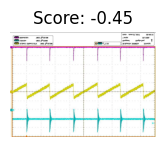

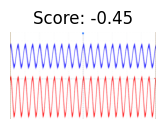

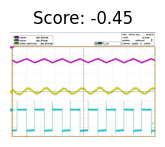

In [14]:
test = retriever_multimodal_image.retrieve(
        query="oscilloscope image showing a sine wave signal",
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.6
        )

# plot retrieved images

retrieved_images = test[1]
for i, img_doc in enumerate(retrieved_images):
    img_path = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, len(retrieved_images), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {img_doc['score']:.2f}")
        plt.show()

In [15]:
class RetrieverText:
    def __init__(self, vector_db, embedding_manager):
        self.vector_db = vector_db
        self.embedding_manager = embedding_manager

        
    def retrieve(self, query, top_k, match_threshold=-0.5):
        
        print(f"Retrieving {top_k} document chunks...")
        
        try:
            query_embedding = self.embedding_manager.create_embeddings(query)[0].tolist()
            results = self.vector_db.collection.query(
                query_embeddings=[query_embedding],
                n_results=top_k
            )
            
            results_list = []
            
            if results["ids"][0]:
                for i in range(len(results["ids"][0])):
                    score = 1 - results["distances"][0][i]  
                    if score >= match_threshold:     # cosine distance <= 1.5 seems reasonable here
                        result = {
                            "id": results["ids"][0][i],
                            "document": results["documents"][0][i],
                            "metadata": results["metadatas"][0][i],
                            "modality": "text",
                            "score": score
                        }
                        results_list.append(result)
                print(f"Retrieved {len(results_list)} documents above the threshold of {match_threshold}.")
            else:
                print("No documents retrieved.")
            
                
            
            return results_list            
            
        except Exception as exc:
            print(f"Error retrieving: {exc}")
            raise
    
    


retriever_txt = RetrieverText(vector_db=vector_db_manager_txt,
embedding_manager=embedding_manager_txt)
retriever_pdf = RetrieverText(vector_db=vector_db_manager_pdf,
embedding_manager=embedding_manager_txt)

In [16]:
results = retriever_txt.retrieve(query="how large is ooland", top_k=3)
print(results)

Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s]

Retrieved 3 documents above the threshold of -0.5.
[{'id': 'doc_f4e63154c7f04852_0', 'document': 'Ooland — An Illustrated Geography\n\n**Location (fictional):** The archipelagic realm of Ooland lies between the temperate currents of the Greater Meridian and the warm gyres of the Saffron Sea.\n**Area:** Approx. 186,000 km² (main island chain and offshore isles)\n**Major Regions:** The Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, Emberfjord Highlands\n**Climate Range:** Alpine tundra to humid tropical, with pronounced regional microclimates', 'metadata': {'source_type': 'text', 'length': 480, 'source': '..\\documents\\texts\\geographyofooland.txt', 'doc_index': 0}, 'modality': 'text', 'score': 0.21016305685043335}, {'id': 'doc_e98336ea2e804999_1', 'document': "Ooland is a country of dramatic contrasts: a stitched landscape where knife-edged mountain ridges give way in a single day's travel to wide river basins, glassy coastal flats, and patchwork or

In [17]:
results = retriever_pdf.retrieve(query="what are the shortcomings of multimodal rag", top_k=3)
print(results)

Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s]

Retrieved 3 documents above the threshold of -0.5.
[{'id': 'doc_f16b5adeead9407d_240', 'document': 'defined as r = G(q, X).\nRelated Works Multimodal RAG is a rapidly\nemerging field, yet a comprehensive survey dedi-\ncated to its recent advancements remains lacking.\nWhile over ten surveys discuss RAG-related topics\nsuch as Agentic RAG (Singh et al., 2025), none\nspecifically focus on the multimodal setting. To\nour knowledge, the only relevant work (Zhao et al.,\n2023a) categorizes multimodal RAGs by applica-\ntion and modality. In contrast, our survey adopts\na more innovation-driven perspective, offering a\ndetailed taxonomy and addressing recent trends and\nopen challenges. We review over 100 recent papers,\nprimarily from the ACL Anthology, reflecting the\n2', 'metadata': {'length': 661, 'source_type': 'pdf', 'author': '', 'moddate': '2025-10-21T04:05:55+02:00', 'subject': '', 'format': 'PDF 1.7', 'keywords': '', 'modDate': "D:20251021040555+02'00'", 'creator': 'PDFium', 'total_

### Language Model Setup

In [18]:
""" Here I will set up multiple open source and/or proprietary LLMs for RAG
    
    I will use prompt templates to generate responses based on retrieved context.
    I will implement a simple RAG class and advanced RAG class, which take different llms as input.
    Each llm will have its own input prompt template.
    I will try to modularize the code as much as possible (i.e. same RAG class can take different llms as input).
    Models I plan to use:
    - Groq Qwen 3.2 32B
    - LlaVa 2 13B (or 7B)
    
    I will try to focus more on LLMs hosted on Groq and HF, also LLMs which use openai API, also LLMs using local inference (if time permits).
    
    In this cell I will set up LLMs and their prompt templates, and in the next cell I will set up RAG classes.
    
"""


groq_api_key = os.getenv("GROQ_API_KEY")


query = "testquery"
context = "testcontext"
def message_general(query, context):
    return [
        SystemMessage(content="You are a helpful assistant that provides concise answers."),
        HumanMessage(content=f"Use the following context to answer the question concisely.\n\nContext:\n{context}\n\nQuestion: {query}\n\nAnswer:"),
    ]
    
def message_expander(query, length):
    return [
        SystemMessage(content="You are a helpful assistant that expands user queries into detailed, specific queries for document retrieval."),
        HumanMessage(content=f"Expand the following query to approximately {length} characters, adding relevant details and context to improve retrieval accuracy.\n\nQuery: {query}\n\nExpanded Query:"),
    ]
    
def message_cot(query):
    return [
        SystemMessage(content="You are a helpful assistant that expands user questions into step-by-step reasoning paths, asking intermediate questions to improve document retrieval accuracy."),
        HumanMessage(content=f"Expand the following question into a step-by-step reasoning path, formulating intermediate questions to guide document retrieval.\n\nQuestion: {query}\n\nReasoning Path:"),
    ]
    
def message_summarizer(message):
    return [
        SystemMessage(content="You are a helpful assistant that summarizes long contexts into concise summaries."),
        HumanMessage(content=f"Summarize the following context concisely, focusing on key points and relevant information.\n\nContext:\n{message}\n\nSummary:"),
    ]

# Setting up LLMs
llm_qwen = ChatGroq(groq_api_key=groq_api_key,model_name="qwen/qwen3-32b",temperature=0.1,max_tokens=1024)
llm_llama31 = ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant",temperature=0.1,max_tokens=1024)
llm_gpt_oss = ChatGroq(groq_api_key=groq_api_key,model_name="openai/gpt-oss-20b",temperature=0.1,max_tokens=1024)



### RAG Pipeline Class

In [19]:
class SimpleRAG:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm
        self.message_history = []
        
    def generate_response(self, query, top_k=3, match_threshold=-0.5):
        
        print(f"Generating response for query: {query}")
        try:
            retrieved_docs = self.retriever.retrieve(query=query, top_k=top_k, match_threshold=match_threshold)
            
            # I test only with my documents, so I do not want generation without context. You can remove this return to continue generation without context.        
            if not retrieved_docs:
                return ("No relevant documents found.")
            
            context = "\n\n".join([doc["document"] for doc in retrieved_docs])
            print(f"Context for LLM:\n{context[:500]}...\n")
            
            messages = message_general(query=query, context=context)
            
            response = self.llm.invoke(messages)
            answer = response.content
            
            if answer:
                print(f"Answer received from LLM.")
                
            # add to message history
            self.message_history.append({
                "query": query,
                "context": context,
                "answer": answer
            })
            
            return answer
        
        except Exception as exc:
            print(f"Error generating response: {exc}")
            raise
        
        
rag_qwen = SimpleRAG(retriever=retriever_txt, llm=llm_qwen)
response_qwen_related = rag_qwen.generate_response(query="what can you do in ooland?", top_k=3) 
print("\n-----------------\n")
print("Response from Qwen LLM:\n")
print(response_qwen_related)
response_qwen_unrelated = rag_qwen.generate_response(query="explain quantum computing in simple terms", top_k=3)
print("Response from Qwen LLM:\n")
print(response_qwen_unrelated)
print("\n-----------------\n")

rag_llama31 = SimpleRAG(retriever=retriever_pdf, llm=llm_llama31)
response_llama31_related = rag_llama31.generate_response(query="how is a stupid person defined", top_k=3)
print("Response from Llama 3.1 LLM:\n")     
print(response_llama31_related)
response_llama31_unrelated = rag_llama31.generate_response(query="explain black holes in simple terms", top_k=3)
print("Response from Llama 3.1 LLM:\n")
print(response_llama31_unrelated)
print("\n-----------------\n")


Generating response for query: what can you do in ooland?
Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.32it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
For travelers and scholars alike, Ooland rewards slow observation. It is a country where the feel of a place changes with each hour — a fog-stitched morning in the fjords, a glittering afternoon on the lowland flats, and a night when stars seem to pool against the Glass Spine’s silhouette. The land’s physical contours are not merely backdrop but active participants in daily life: shaping weather, economies, belief systems, and the practical rhythms of its peoples. In short, Ooland is a geography...



Answer received from LLM.

-----------------

Response from Qwen LLM:

<think>
Okay, let's see. The user is asking what you can do in Ooland. The context provided is a detailed description of the fictional country Ooland from an illustrated geography. The answer needs to be concise, so I need to extract the key activities or experiences based on the given information.

First, the context mentions that Ooland has diverse landscapes like fjords, lowland flats, the Glass Spine mountains, river basins, coastal flats, and orchards. These geographical features suggest various activities. For example, the Glass Spine's glaciers and rivers might be good for hiking or exploring glacial formations. The different regions like the Verdant Lowlands or Emberfjord Highlands could offer opportunities for nature observation or cultural experiences.

The text also talks about the land's physical contours being active participants in daily life, affecting weather, economies, and belief systems. This impl

Batches: 100%|██████████| 1/1 [00:00<?, ?it/s]


Retrieved 0 documents above the threshold of -0.5.
Response from Qwen LLM:

No relevant documents found.

-----------------

Generating response for query: how is a stupid person defined
Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 64.43it/s]


Retrieved 0 documents above the threshold of -0.5.
Response from Llama 3.1 LLM:

No relevant documents found.
Generating response for query: explain black holes in simple terms
Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 83.67it/s]

Retrieved 0 documents above the threshold of -0.5.
Response from Llama 3.1 LLM:

No relevant documents found.

-----------------



In [20]:
class AdvancedRAG:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm
        self.message_history = []
        
    def generate_response(self, query, top_k=3, match_threshold=-0.5, preprocess_type=None, chunk_size=1000, summarize=False):
        
        print(f"Generating response for query: {query}")
        try:
            
            # Preprocessing the query into an expanded or chain-of-thought format for better retrieval
            if preprocess_type:
                if preprocess_type == "expand":
                    expander_query = message_expander(query=query, length=chunk_size)
                    response = self.llm.invoke(expander_query)
                    query_retrieval = response.content
                    print(f"Expanded retrieval query: {query_retrieval}")
                if preprocess_type == "chain_of_thought":
                    cot_query = message_cot(query=query)
                    response = self.llm.invoke(cot_query)
                    query_retrieval = response.content
                    print(f"Chain of thought retrieval query: {query_retrieval}")
            else:
                query_retrieval = query
            
            retrieved_docs = self.retriever.retrieve(query=query_retrieval, top_k=top_k, match_threshold=match_threshold)
            
            # I test only with my documents, so I do not want generation without context. You can remove this return to continue generation without context.
            if not retrieved_docs:
                return {"answer": "No relevant documents found. Stopping to avoid hallucinations.", "sources": None, "retrieved_docs": None, "message_history": self.message_history}
            
            context = "\n\n".join([doc["document"] for doc in retrieved_docs])
            sources = [{"source": doc["metadata"].get("source", "unknown"), "score": doc["score"]} for doc in retrieved_docs]
            
            print(f"Context for LLM:\n{context[:500]}...\n")
            
            messages = message_general(query=query, context=context)
            
            response = self.llm.invoke(messages)
            answer = response.content
            
            
            if answer:
                print(f"Answer received from LLM.")
                
            if summarize:
                # Summarization step
                summarization_prompt = message_summarizer(message=answer)
                summary_response = self.llm.invoke(summarization_prompt)
                answer = summary_response.content
                print(f"Summarized Answer received from LLM.")
                
            # add to message history
            self.message_history.append({
                "query": query,
                "context": context,
                "answer": answer
            })
            
            return {"answer": answer, "sources": sources, "retrieved_docs": retrieved_docs, "message_history": self.message_history}
        
        except Exception as exc:
            print(f"Error generating response: {exc}")
            raise

In [21]:

# Qwen 3.2 Advanced RAG tests on text retriever
print("\n----------------------------------------------------------------------------------------\n")
advancedrag_qwen = AdvancedRAG(retriever=retriever_txt, llm=llm_qwen)
response_adv_qwen = advancedrag_qwen.generate_response(query="what are the main attractions in ooland?", top_k=3, preprocess_type=None, summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Qwen LLM without preprocessing:\n")
print(response_adv_qwen["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_qwen["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")
    
print("\n----------------------------------------------------------------------------------------\n")
advancedrag_qwen_expanded = AdvancedRAG(retriever=retriever_txt, llm=llm_qwen)
response_adv_qwen_expanded = advancedrag_qwen_expanded.generate_response(query="what are the main attractions in ooland?", top_k=3, preprocess_type="expand", summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Qwen LLM with query expansion:\n")
print(response_adv_qwen_expanded["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_qwen_expanded["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")

print("\n----------------------------------------------------------------------------------------\n")    
advancedrag_qwen_cot = AdvancedRAG(retriever=retriever_txt, llm=llm_qwen)
response_adv_qwen_cot = advancedrag_qwen_cot.generate_response(query="what are the main attractions in ooland?", top_k=3, preprocess_type="chain_of_thought", summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Qwen LLM with chain-of-thought:\n")
print(response_adv_qwen_cot["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_qwen_cot["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")




----------------------------------------------------------------------------------------

Generating response for query: what are the main attractions in ooland?
Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 47.82it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
Ooland — An Illustrated Geography

**Location (fictional):** The archipelagic realm of Ooland lies between the temperate currents of the Greater Meridian and the warm gyres of the Saffron Sea.
**Area:** Approx. 186,000 km² (main island chain and offshore isles)
**Major Regions:** The Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, Emberfjord Highlands
**Climate Range:** Alpine tundra to humid tropical, with pronounced regional microclimates

For travelers and ...



Answer received from LLM.

-----------------

Advanced RAG Response from Qwen LLM without preprocessing:

<think>
Okay, let's see. The user is asking about the main attractions in Ooland based on the provided context. First, I need to parse the context carefully.

The context describes Ooland as an archipelago with various regions: Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, and Emberfjord Highlands. Each of these regions probably has unique features. The climate ranges from alpine tundra to humid tropical, so there's a lot of diversity. The text mentions things like fog in the fjords, glittering lowlands, and starry nights against the Glass Spine. 

The conservation part talks about coastal tourism, fisheries, mineral extraction in the Sable Expanse, and geothermal energy. So maybe these areas are attractions. The Glass Spine is mentioned as a silhouette against stars, which could be a scenic spot. The Emberfjord Highlands might have the fog-sti

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.91it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
Ooland — An Illustrated Geography

**Location (fictional):** The archipelagic realm of Ooland lies between the temperate currents of the Greater Meridian and the warm gyres of the Saffron Sea.
**Area:** Approx. 186,000 km² (main island chain and offshore isles)
**Major Regions:** The Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, Emberfjord Highlands
**Climate Range:** Alpine tundra to humid tropical, with pronounced regional microclimates

For travelers and ...



Answer received from LLM.

-----------------

Advanced RAG Response from Qwen LLM with query expansion:

<think>
Okay, let's tackle this question. The user is asking about the main attractions in Ooland based on the provided context. First, I need to parse the context carefully.

The context describes Ooland as an archipelago with various regions: Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, and Emberfjord Highlands. Each of these regions likely has unique features. The Glass Spine is mentioned as a long mountainous island with high peaks of pale, translucent stone, glaciers, and snowfields. The rivers from there feed into fertile valleys. The climate ranges from alpine tundra to humid tropical, with microclimates. The text also mentions dramatic contrasts like mountain ridges, river basins, coastal flats, and orchards.

The main attractions would probably be these distinct regions and their features. The Glass Spine is highlighted as a dominant f

Batches: 100%|██████████| 1/1 [00:00<00:00, 26.57it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
Ooland — An Illustrated Geography

**Location (fictional):** The archipelagic realm of Ooland lies between the temperate currents of the Greater Meridian and the warm gyres of the Saffron Sea.
**Area:** Approx. 186,000 km² (main island chain and offshore isles)
**Major Regions:** The Glass Spine, Verdant Lowlands, Sable Expanse, Lunarmar Coast, High Fen Archipelago, Emberfjord Highlands
**Climate Range:** Alpine tundra to humid tropical, with pronounced regional microclimates

For travelers and ...



Answer received from LLM.

-----------------

Advanced RAG Response from Qwen LLM with chain-of-thought:

<think>
Okay, let's see. The user is asking about the main attractions in Ooland based on the provided context. First, I need to parse the context carefully.

The context describes Ooland as an archipelago with various regions like the Glass Spine, Verdant Lowlands, Sable Expanse, etc. Each of these regions probably has unique features. The Glass Spine is mentioned as part of a continental rift system with geothermal vents and hot springs, leading to thermal baths and spa towns. That's a key point for attractions there.

The Verdant Lowlands might be more about lush, green areas, maybe agriculture or scenic beauty. The Sable Expanse isn't detailed, but the name suggests maybe a desert or sandy area. The Lunarmar Coast could be coastal attractions, maybe beaches or cliffs. The High Fen Archipelago might have wetlands or marshes. The Emberfjord Highlands probably have fjords and mayb

In [29]:
# Llama 3.1 Advanced RAG tests on pdf retriever

print("\n----------------------------------------------------------------------------------------\n")    
advancedrag_llama31 = AdvancedRAG(retriever=retriever_pdf, llm=llm_llama31)
response_adv_llama31 = advancedrag_llama31.generate_response(query="what are the limitations in GNSS-denied UAV localization tasks?", top_k=3, preprocess_type=None, summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Llama 3.1 LLM without preprocessing:\n")
print(response_adv_llama31["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_llama31["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")
    
print("\n----------------------------------------------------------------------------------------\n")    
advancedrag_llama31_expanded = AdvancedRAG(retriever=retriever_pdf, llm=llm_llama31)
response_adv_llama31_expanded = advancedrag_llama31_expanded.generate_response(query="what are the limitations in GNSS-denied UAV localization tasks?", top_k=3, preprocess_type="expand", summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Llama 3.1 LLM with query expansion:\n")
print(response_adv_llama31_expanded["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_llama31_expanded["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")

print("\n----------------------------------------------------------------------------------------\n")       
advancedrag_llama31_cot = AdvancedRAG(retriever=retriever_pdf, llm=llm_llama31)
response_adv_llama31_cot = advancedrag_llama31_cot.generate_response(query="what are the limitations in GNSS-denied UAV localization tasks?", top_k=3, preprocess_type="chain_of_thought", summarize=False)
print("\n-----------------\n")
print("Advanced RAG Response from Llama 3.1 LLM with chain-of-thought:\n")
print(response_adv_llama31_cot["answer"])
print("Retrieved doc accuracy scores:")
for doc in response_adv_llama31_cot["retrieved_docs"]:
    print(f"Doc ID: {doc['id']}, Score: {doc['score']}")


----------------------------------------------------------------------------------------

Generating response for query: what are the limitations in GNSS-denied UAV localization tasks?
Retrieving 3 document chunks...


Batches: 100%|██████████| 1/1 [00:00<00:00, 80.55it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
map consisting of georeferenced open-source satellite images.
Experimental results prove that vision-based localization has
comparable accuracy with traditional GNSS-based methods,
which serve as ground truth. Compared to state-of-the-art
Visual Odometry (VO) approaches, our solution is designed for
long-distance, high-altitude UAV ﬂights. Code and datasets are
available at https://github.com/TIERS/wildnav.
Index
Terms—UAV;
MAV;
GNSS-Free;
GNSS-denied;
Vision-based localization; Photogrammetry; ...



Answer received from LLM.

-----------------

Advanced RAG Response from Llama 3.1 LLM without preprocessing:

The limitations in GNSS-denied UAV localization tasks are:

1. Unreliable GNSS signal in environments such as inside buildings.
2. High error rates in GNSS positioning data, ranging from 1 to 20 meters under clear sky conditions.
3. Inability to provide accurate positioning data during long-distance UAV flights without using GNSS.
Retrieved doc accuracy scores:
Doc ID: doc_c49d758282ad40b8_637, Score: 0.15391147136688232
Doc ID: doc_51c6190840dc4f3e_659, Score: 0.1059720516204834
Doc ID: doc_10160c41de794ea2_638, Score: 0.08749860525131226

----------------------------------------------------------------------------------------

Generating response for query: what are the limitations in GNSS-denied UAV localization tasks?
Expanded retrieval query: "Identify and describe the key limitations and challenges associated with GNSS-denied (Global Navigation Satellite System-denied) U

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
map consisting of georeferenced open-source satellite images.
Experimental results prove that vision-based localization has
comparable accuracy with traditional GNSS-based methods,
which serve as ground truth. Compared to state-of-the-art
Visual Odometry (VO) approaches, our solution is designed for
long-distance, high-altitude UAV ﬂights. Code and datasets are
available at https://github.com/TIERS/wildnav.
Index
Terms—UAV;
MAV;
GNSS-Free;
GNSS-denied;
Vision-based localization; Photogrammetry; ...



Answer received from LLM.

-----------------

Advanced RAG Response from Llama 3.1 LLM with query expansion:

The limitations in GNSS-denied UAV localization tasks are:

1. Unreliable GNSS signal in environments such as inside buildings.
2. Difficulty in obtaining accurate positioning data in harsh weather conditions or night.
3. Limited applicability of traditional GNSS-based methods in GNSS-denied environments.
Retrieved doc accuracy scores:
Doc ID: doc_c49d758282ad40b8_637, Score: 0.5084989070892334
Doc ID: doc_10160c41de794ea2_638, Score: 0.4307010769844055
Doc ID: doc_da7858742ee94eba_664, Score: 0.41095471382141113

----------------------------------------------------------------------------------------

Generating response for query: what are the limitations in GNSS-denied UAV localization tasks?
Chain of thought retrieval query: To expand the question into a step-by-step reasoning path, we need to break it down into more specific and manageable sub-questions. Here's a possible 

Batches: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]

Retrieved 3 documents above the threshold of -0.5.
Context for LLM:
map consisting of georeferenced open-source satellite images.
Experimental results prove that vision-based localization has
comparable accuracy with traditional GNSS-based methods,
which serve as ground truth. Compared to state-of-the-art
Visual Odometry (VO) approaches, our solution is designed for
long-distance, high-altitude UAV ﬂights. Code and datasets are
available at https://github.com/TIERS/wildnav.
Index
Terms—UAV;
MAV;
GNSS-Free;
GNSS-denied;
Vision-based localization; Photogrammetry; ...



Answer received from LLM.

-----------------

Advanced RAG Response from Llama 3.1 LLM with chain-of-thought:

In GNSS-denied environments, such as inside buildings or in areas with dense foliage, the GNSS signal is unreliable or unavailable. This can lead to inaccurate or no positioning data, making it challenging for UAVs to navigate safely.
Retrieved doc accuracy scores:
Doc ID: doc_c49d758282ad40b8_637, Score: 0.33432865142822266
Doc ID: doc_d7a67b8798ab4b82_646, Score: 0.2329491376876831
Doc ID: doc_10160c41de794ea2_638, Score: 0.22176378965377808


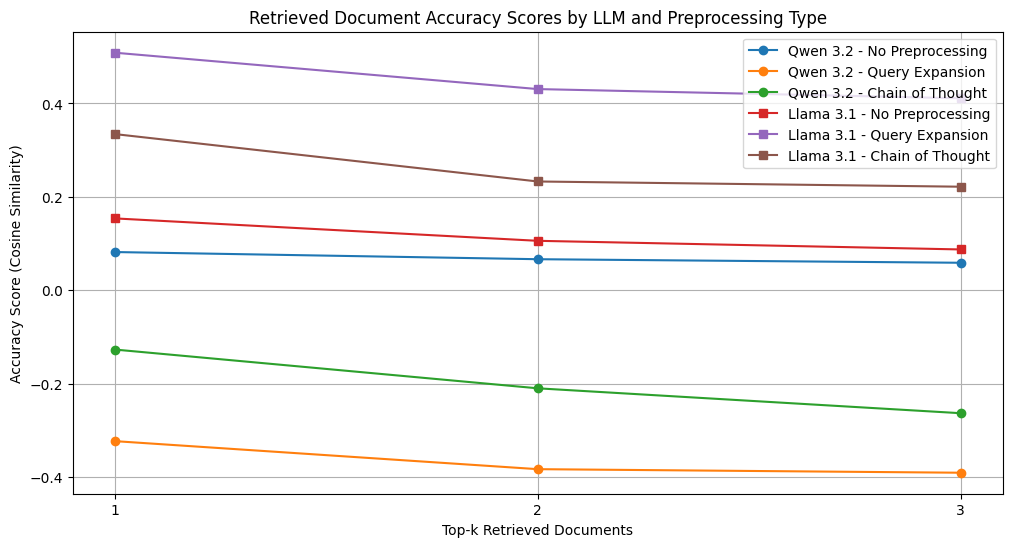

In [30]:
# Plot and compare the accuracy scores without, with query expansion, and with chain-of-thought preprocessing for both LLMs. put both llms and the results from above into lists and plot them using matplotlib.
llm_names = ["Qwen 3.2", "Llama 3.1"]
accuracy_scores_no_preproc = [
    [doc["score"] for doc in response_adv_qwen["retrieved_docs"]],
    [doc["score"] for doc in response_adv_llama31["retrieved_docs"]]
]
accuracy_scores_query_expansion = [
    [doc["score"] for doc in response_adv_qwen_expanded["retrieved_docs"]],
    [doc["score"] for doc in response_adv_llama31_expanded["retrieved_docs"]]
]
accuracy_scores_chain_of_thought = [
    [doc["score"] for doc in response_adv_qwen_cot["retrieved_docs"]],
    [doc["score"] for doc in response_adv_llama31_cot["retrieved_docs"]]
]
x = range(1, 4)  # Top-k values
plt.figure(figsize=(12, 6))
plt.plot(x, accuracy_scores_no_preproc[0], marker='o', label='Qwen 3.2 - No Preprocessing')
plt.plot(x, accuracy_scores_query_expansion[0], marker='o', label='Qwen 3.2 - Query Expansion')
plt.plot(x, accuracy_scores_chain_of_thought[0], marker='o', label='Qwen 3.2 - Chain of Thought')
plt.plot(x, accuracy_scores_no_preproc[1], marker='s', label='Llama 3.1 - No Preprocessing')
plt.plot(x, accuracy_scores_query_expansion[1], marker='s', label='Llama 3.1 - Query Expansion')
plt.plot(x, accuracy_scores_chain_of_thought[1], marker='s', label='Llama 3.1 - Chain of Thought')
plt.title('Retrieved Document Accuracy Scores by LLM and Preprocessing Type')
plt.xlabel('Top-k Retrieved Documents')
plt.ylabel('Accuracy Score (Cosine Similarity)')
plt.xticks(x)
plt.legend()
plt.grid()

### Llava (god save me)

In [ ]:
# 8-bit quantization config for llava (local inference)

quantization_config = BitsAndBytesConfig(
load_in_8bit=True,
low_cpu_mem_usage=True,
use_flash_attention_2=True
)

def load_llava_model(model_id):
    processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
    model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True)
    model.to("cuda:0")
    return model, processor

model_llava, processor_llava = load_llava_model("llava-hf/llava-1.5-7b-hf")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


In [ ]:
# prepare image and text prompt, using the appropriate prompt template

image_path = documents_path + "pdfs_images/extracted_images/INA219/INA219_p30_x847_w288_h96.png"
image = Image.open(image_path)

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt

# Each value in "content" has to be a list of dicts with types ("text", "image")

conversation = [
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What is shown in this image?"},
        {"type": "image",
        "image": image_path},
      ],
    },
  ]

#prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)
#inputs = processor_llava(images=image, text=prompt, return_tensors="pt").to("cuda:0")
prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor_llava(images=image, text=prompt, return_tensors="pt").to("cuda:0")

In [ ]:
plt.imshow(image)


In [ ]:
# autoregressively complete prompt

output = model_llava.generate(**inputs, max_new_tokens=100)

print(processor_llava.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]  
What is shown in this image? [/INST] The image appears to be a radar chart, which is a type of multi-dimensional plot that displays values for multiple quantitative variables represented on axes starting from the same point. This particular radar chart is showing the performance of different models or systems across various metrics.

The axes represent different metrics or benchmarks, such as MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-


### QWEN 3VL

In [4]:
model_qwen = Qwen3VLForConditionalGeneration.from_pretrained(
"Qwen/Qwen3-VL-8B-Instruct", dtype="auto", device_map="cpu"
)
processor_qwen = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


In [8]:
image_path = documents_path + "pdfs_images/extracted_images/INA219/INA219_p30_x847_w288_h96.png"
image = Image.open(image_path)

# Helper function for multimodal messages in Qwen format


messages = [
        {
            "role": "user", 
            "content": [
                {"type": "text", "text": "What is shown in this image, describe in detail."},
                {"type": "image", "image": image},
                
            ]
        }
    ]

# Process the messages correctly

inputs = processor_qwen.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
            )
inputs = inputs.to(model_qwen.device)

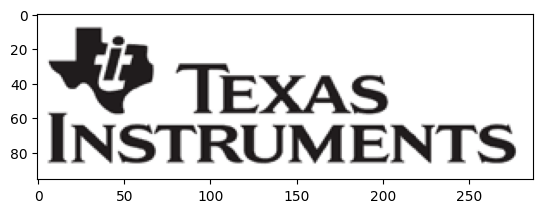

In [9]:
plt.imshow(image)


In [10]:
# Inference: Generation of the output

generated_ids = model_qwen.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
output_text = processor_qwen.batch_decode(generated_ids_trimmed, skip_special_tokens=True,
                                          clean_up_tokenization_spaces=True)
print(output_text)  


KeyboardInterrupt: 

### Building The Multimodal Pipeline

In [ ]:
def build_llava_inputs(
    processor_llava,
    query,
    text_context,
    image_paths,
    max_images = 1,
    device = "cuda:0"):
    
    """
    Build inputs for LLaVA
    Uses up to `max_images` from image_paths. The number of retrieved images (top_k) must be equal to this one.
    """
    # textual part
    text_content = (
        "You are a helpful assistant for industrial manuals.\n\n"
        "Use the following text context and image(s) to answer the question.\n\n"
        f"Text Context:\n{text_context}\n\n"
        f"Question: {query}\n\n"
        "Answer:"
    )

    # Open images 
    selected_paths = image_paths[:max_images]
    images = [Image.open(p).convert("RGB") for p in selected_paths]

    # Conversation in LLaVA format
    content = [{"type": "text", "text": text_content}]
    # LLaVA expects dummy "image" entries in the chat template, but real images are passed separately to the processor.
    for p in selected_paths:
        content.append({"type": "image"})

    conversation = [
        {
            "role": "user",
            "content": content,
        }
    ]

    prompt = processor_llava.apply_chat_template(conversation, add_generation_prompt=True)

    inputs = processor_llava(images=images, text=prompt, return_tensors="pt").to(device)

    return inputs


def build_qwen_inputs(processor_qwen, query, text_context, image_paths, max_images = 1):
    """
    Build inputs for Qwen3-VL
    Up to `max_images` from image_paths (retrieved image number top_k must be equal to this one).
    """
    selected_paths = image_paths[:max_images]
    images = [Image.open(p).convert("RGB") for p in selected_paths]

    text_content = (
        "You are a helpful assistant for industrial manuals.\n\n"
        "Use the following text context and image(s) to answer the question.\n\n"
        f"Text Context:\n{text_context}\n\n"
        f"Question: {query}\n\n"
        "Answer:"
    )

    # Qwen3-VL expects messages with image objects directly
    content = []
    for img in images:
        content.append({"type": "image", "image": img})
    content.append({"type": "text", "text": text_content})

    messages = [
        {
            "role": "user",
            "content": content,
        }
    ]

    inputs = processor_qwen.apply_chat_template(messages,
                            tokenize=True,
                            add_generation_prompt=True,
                            return_dict=True,
                            return_tensors="pt")

    return inputs


In [ ]:
class AdvancedMultimodalRAG:
    """
    Advanced multimodal RAG for image + text retrieval and generation
    using either LLaVA or Qwen3-VL as the multimodal model.

    - Uses RetrieverMultiModal class to get:
        * text chunks from your text vector DB 
        * image docs (paths in metadata) from your image vector DB
    - Extracts the page texts from pages where images were found
    - Builds a text context from retrieved text + page_text from images
    - Selects top-k images and passes them to the chosen backend
    - Optional: query expansion / chain-of-thought via a text LLM
    - Optional: summarization of the final answer
    
    - future: hierarchical retrieval (crop pages, then retrieve larger crops or full pages based on initial retrieval)
    - future: cot retrieval query for image retrieval separately, in the form of image descriptions?
    """

    def __init__(
        self,
        retriever_multimodal,
        model_llava=None,
        processor_llava=None,
        model_qwen=None,
        processor_qwen=None,
        text_llm=None):         # optional: Groq text LLM for query expansion / summarization
    
        self.retriever_multimodal = retriever_multimodal

        self.model_llava = model_llava
        self.processor_llava = processor_llava

        self.model_qwen = model_qwen
        self.processor_qwen = processor_qwen

        self.text_llm = text_llm
        self.message_history = []

    def _preprocess_query(self, query, preprocess_type=None, chunk_size=1000):
        """
        Optional query preprocessing using a text LLM (Groq), if provided.

        preprocess_type:
            - None
            - "expand"
            - "chain_of_thought"
            - future: cot for image retrieval in caption style
        """
        if not preprocess_type or self.text_llm is None:
            return query

        if preprocess_type == "expand":
            expander_query = message_expander(query=query, length=chunk_size)
            response = self.text_llm.invoke(expander_query)
            query_retrieval = response.content
            print("Expanded retrieval query:\n", query_retrieval[:500], "...\n")
            return query_retrieval

        if preprocess_type == "chain_of_thought":
            cot_query = message_cot(query=query)
            response = self.text_llm.invoke(cot_query)
            query_retrieval = response.content
            print("Chain-of-thought retrieval query:\n", query_retrieval[:500], "...\n")
            return query_retrieval

        # Fallback to normal query if not selected
        return query

    def _build_text_context(self, text_docs, image_docs, max_text_chunks):
        """
        Build a structured text context:
        - Section 1: Retrieved text chunks
        - Section 2: Page text extracted from image locations
        """

        sections = []

        # ------------------------------------------
        # Retrieved text chunks
        text_parts = []
        for i, doc in enumerate(text_docs[:max_text_chunks]):
            chunk_label = f"[Text Chunk {i+1}]"
            chunk_body = doc["document"]
            if chunk_body:
                text_parts.append(f"{chunk_label}\n{chunk_body}")

        if text_parts:
            section_text = "### Retrieved Text Chunks\n" + "\n\n".join(text_parts)
            sections.append(section_text)

        # ------------------------------------------
        # Page text from images
        image_text_parts = []
        for j, img_doc in enumerate(image_docs):
            page_text = img_doc["metadata"].get("page_text")
            if page_text:
                img_label = f"[Image Context {j+1}]"
                image_text_parts.append(f"{img_label}\n{page_text}")

        if image_text_parts:
            section_page_text = "### Page Text Near Retrieved Images\n" + "\n\n".join(image_text_parts)
            sections.append(section_page_text)

        # if no context found
        if not sections:
            return ""

        # Combine all sections
        final_context = "\n\n====================\n\n".join(sections)
        return final_context


    def _select_image_paths(self, image_docs, max_images):
        """
        Collect image paths from image_docs' metadata.
        Handles both 'image_path' and 'page_image_path'.
        """
        paths = []
        for img_doc in image_docs:
            p = img_doc["metadata"].get("image_path") or img_doc["metadata"].get("page_image_path")
            if p:
                paths.append(p)
            if len(paths) >= max_images:
                break
        return paths

    def _run_llava(self, query, text_context, image_paths, max_images, max_new_tokens, device):
        
        if self.model_llava is None or self.processor_llava is None:
            raise ValueError("LLaVA model/processor not provided to AdvancedMultimodalRAG.")

        inputs = build_llava_inputs(
            processor_llava=self.processor_llava,
            query=query,
            text_context=text_context,
            image_paths=image_paths,
            max_images=max_images,
            device=device)

        with torch.no_grad():
            output_ids = self.model_llava.generate(
                **inputs,
                max_new_tokens=max_new_tokens)

        # LlavaNextProcessor supports decode
        answer = self.processor_llava.decode(output_ids[0], skip_special_tokens=True)
        return answer

    def _run_qwen(
        self,
        query,
        text_context,
        image_paths,
        max_images,
        max_new_tokens):
        if self.model_qwen is None or self.processor_qwen is None:
            raise ValueError("Qwen3-VL model/processor not provided to AdvancedMultimodalRAG.")

        inputs = build_qwen_inputs(
            processor_qwen=self.processor_qwen,
            query=query,
            text_context=text_context,
            image_paths=image_paths,
            max_images=max_images)

        inputs = inputs.to(self.model_qwen.device)

        with torch.no_grad():
            generated_ids = self.model_qwen.generate(
                **inputs,
                max_new_tokens=max_new_tokens)

        # Trim prompt tokens
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        answer_list = self.processor_qwen.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )
        # single example => take first
        answer = answer_list[0] if len(answer_list) > 0 else ""
        return answer

    def generate_response(
        self,
        query,
        backend="qwen_vl",     # "qwen_vl" or "llava"
        top_k_text=3,
        top_k_image=3,
        match_threshold_text=-0.5,
        match_threshold_image=-0.5,
        max_images=1,
        max_new_tokens=128,
        preprocess_type=None,  # None, "expand", "chain_of_thought"
        chunk_size=1000,
        summarize=False,
        image_query_captioning=False,
        device="cuda:0"):
        """
        Main entry point.

        backend:
            - "qwen_vl" : Qwen3-VL-8B
            - "llava"   : LLaVA v1.6 (Mistral 7B)

        Returns a dict with:
            - "answer"
            - "backend"
            - "query_original"
            - "query_retrieval"
            - "text_context"
            - "image_paths_used"
            - "retrieved_text_docs"
            - "retrieved_image_docs"
            - "sources_text"
            - "sources_image"
            - "message_history"
        """

        print("Generating multimodal response for query:", query)
        # 1) optional query preprocessing
        query_retrieval = self._preprocess_query(
            query=query,
            preprocess_type=preprocess_type,
            chunk_size=chunk_size)
        
        # 2) retrieval
        try:
            text_docs, image_docs = self.retriever_multimodal.retrieve(
                query=query_retrieval,
                top_k_text=top_k_text,
                top_k_image=top_k_image,
                match_threshold_text=match_threshold_text,
                match_threshold_image=match_threshold_image)
        except Exception as exc:
            print("Error during retrieval:", exc)
            raise

        if not text_docs and not image_docs:
            print("No relevant multimodal documents found.")
            result = {
                "answer": "No relevant documents found. Stopping to avoid hallucinations.",
                "backend": backend,
                "query_original": query,
                "query_retrieval": query_retrieval,
                "text_context": "",
                "image_paths_used": [],
                "retrieved_text_docs": [],
                "retrieved_image_docs": [],
                "sources_text": [],
                "sources_image": [],
                "message_history": self.message_history
            }
            self.message_history.append(result)
            return result

        # 3) build text context
        text_context = self._build_text_context(
            text_docs=text_docs,
            image_docs=image_docs,
            max_text_chunks=top_k_text)
        print("Text context length:", len(text_context))

        # 4) image selection
        image_paths_used = self._select_image_paths(
            image_docs=image_docs,
            max_images=max_images)
        print("Using", len(image_paths_used), "image(s) for generation.")

        # 5) run the selected backend
        if backend == "llava":
            answer = self._run_llava(
                query=query,
                text_context=text_context,
                image_paths=image_paths_used,
                max_images=max_images,
                max_new_tokens=max_new_tokens,
                device=device)
            
        elif backend == "qwen_vl":
            answer = self._run_qwen(
                query=query,
                text_context=text_context,
                image_paths=image_paths_used,
                max_images=max_images,
                max_new_tokens=max_new_tokens)
        else:
            raise ValueError("Unknown backend: {} (use 'llava' or 'qwen_vl')".format(backend))

        print("Answer from backend {}: \n{}\n".format(backend, answer[:500]))

        # 6) optional summarization using text LLM
        if summarize and self.text_llm is not None:
            print("Summarizing answer with text LLM...")
            summarization_prompt = message_summarizer(message=answer)
            summary_response = self.text_llm.invoke(summarization_prompt)
            answer = summary_response.content
            print("Summarized answer:\n", answer[:500], "...\n")

        # 7) collect sources
        sources_text = []
        for doc in text_docs:
            sources_text.append({
                "id": doc["id"],
                "score": doc["score"],
                "metadata": doc["metadata"],
            })

        sources_image = []
        for doc in image_docs:
            p = doc["metadata"].get("image_path") or doc["metadata"].get("page_image_path")
            sources_image.append({
                "id": doc["id"],
                "score": doc["score"],
                "metadata": doc["metadata"],
                "image_path": p,
            })

        # 8) build result
        result = {
            "answer": answer,
            "backend": backend,
            "query_original": query,
            "query_retrieval": query_retrieval,
            "text_context": text_context,
            "image_paths_used": image_paths_used,
            "retrieved_text_docs": text_docs,
            "retrieved_image_docs": image_docs,
            "sources_text": sources_text,
            "sources_image": sources_image,
            "message_history": self.message_history,
        }

        self.message_history.append(result)
        return result


In [ ]:
retriever_multimodal_image = RetrieverMultiModal(vector_db_text=vector_db_manager_txt,
                            vector_db_image=vector_db_manager_pdf_images,
                            embedding_manager_text=embedding_manager_txt,
                            embedding_manager_image=embedding_manager_images)

mm_rag = AdvancedMultimodalRAG(
    retriever_multimodal=retriever_multimodal_image,
    model_llava=model_llava,
    processor_llava=processor_llava,
    model_qwen=model_qwen,
    processor_qwen=processor_qwen,
    text_llm=llm_llama31,
)

In [ ]:
query_qwen = "What is shown in this image? Describe in detail."


result_qwen = mm_rag.generate_response(
    query="Explain how to connect the INA219 current sensor to a microcontroller.",
    backend="qwen_vl",
    top_k_text=3,
    top_k_image=2,
    max_images=2,
    preprocess_type="expand",   # or None / "chain_of_thought"
    summarize=False,
)